# Indian Institute of Technolgy, Ropar
# B. Tech Project
## Prediction of costs for EV charging
### Team Members
* Yash Jain - 2019EEB1208
* Swapnil Saurav - 2019EEB1204
* Aishwarya Pal - 2019EEB1136

Under the Guidance of Dr. K. R. Sekhar and Nikhil.

Department of Electrical Engineering.

The overall Project is broken into subparts as follows:
1. Prediction of Irradiance from current weather data.
2. Prediction of OC Voltage from Irradiance and Temperature.
3. Estimation of cost of EV charging from grid and solar power availability.

We have used ML for the first two parts. 



In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
# for data handeling
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# for the model
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import explained_variance_score, mean_squared_error, r2_score

# for API handeling
import requests
import json
from datetime import datetime
import pytz

# import tensorflow as tf
# from sklearn import tree
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.linear_model import LogisticRegression
# from sklearn.ensemble import RandomForestRegressor

In [3]:
# loading the datasets
root = ""
combined_data = pd.read_csv(root+"combined_data.csv");
matlab_data = pd.read_csv(root+"datasolar.csv")

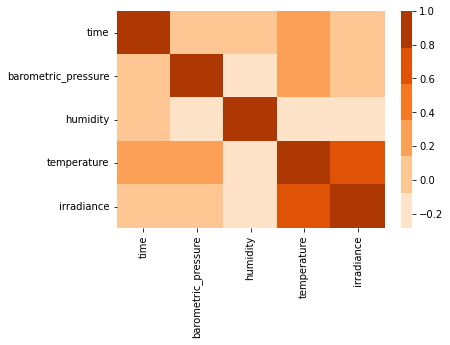

In [4]:
correlation = combined_data.corr(method = 'pearson')
sns.heatmap(correlation, cmap=sns.color_palette("Oranges"))

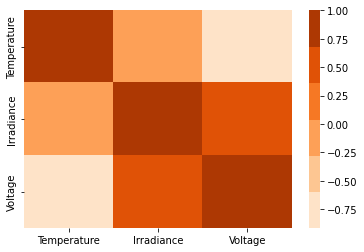

In [5]:
correlation = matlab_data.corr(method = 'pearson')
sns.heatmap(correlation, cmap=sns.color_palette("Oranges"))

In [6]:
# The below function will create the model, split the data, fit the model and checks the accuracies.
def model_maker(data,key):
    # creating the model.
    regressor = ExtraTreesRegressor(n_estimators = 100)

    # extracting X and Y from the data.
    df2 = data.iloc[:,:-1]
    X = df2.to_numpy()
    Y = data[key].to_numpy()

    # X_train and Y_train for training the model. X_test, Y_test for testing.
    X_train, X_test, Y_train, Y_test = train_test_split(X,Y, train_size=0.80, random_state=1)

    #fitting the model
    regressor.fit(X_train, Y_train)

    # Calcuting the accuracies
    accuracies = cross_val_score(estimator = regressor, X = X_train,y = Y_train, cv = 2, scoring = 'r2')
    accuracy = accuracies.mean()
    print('\n--------------------------------------------------\n')
    print('From Training Data:')
    print(f'r2 = {accuracy}\n')


    # predicting radiance and accuracy calculation
    y_pred = regressor.predict(X_test)
    explained_variance_score2 = explained_variance_score(Y_test, y_pred)
    mean_squared_error2 = mean_squared_error(Y_test, y_pred)
    r_squared = r2_score(Y_test, y_pred)

    
    print('From Testing Data:')
    print(f'explained variance = {explained_variance_score2}')
    print(f'mse = {mean_squared_error2}')
    print(f'r2 = {r_squared}')

    plt.plot(Y_test[:50])
    plt.plot(y_pred[:50])
    plt.show()
    print('\n--------------------------------------------------\n')
    return regressor


--------------------------------------------------

From Training Data:
r2 = 0.9110715887831556

From Testing Data:
explained variance = 0.922006153358413
mse = 7720.9484445019125
r2 = 0.9220060590795053


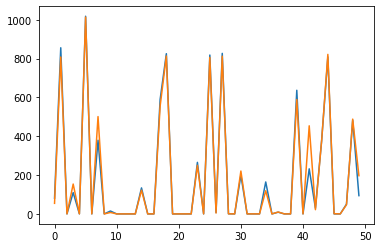


--------------------------------------------------


--------------------------------------------------

From Training Data:
r2 = 0.9949630219013059

From Testing Data:
explained variance = 0.9993321417055034
mse = 0.7277926634869137
r2 = 0.9993314392876463


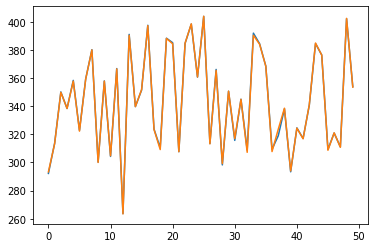


--------------------------------------------------



In [7]:
# creating the models for irradiance and voltage.
irradiance_model = model_maker(combined_data,'irradiance')
voltage_model = model_maker(matlab_data,'Voltage')

In [8]:
# The below function calculates the current time of the region in seconds after 00:00:00.
def currentTimeCalc(region='Asia/Calcutta'):
    tz = pytz.timezone(region)
    now = datetime.now(tz).strftime("%H:%M:%S")
    y = now.split(":")
    currTime = int(y[0])*3600 + int(y[1])*60 + int(y[2])
    return currTime
    
# The below function handles the API call.
def API_handler(lat=30.9688367,lon=76.526088):
    url = "https://api.openweathermap.org/data/2.5/weather?lat="+str(lat)+"&lon="+str(lon)+"&appid={APP_ID}"
    response = requests.get(url)

    if response.status_code == 200:
        print("Sucessfully fetched the data from the API.")
    else:
        print(f"Hello User!, there's a {response.status_code} error with your request. Can not fetch the data.")

    fetched_data = response.json()

    currTime = currentTimeCalc()
    currPress = fetched_data['main']['pressure'] / 33.86388666667           # hPa to inHg.
    currTemp = fetched_data['main']['temp'] - 273.15                        # K to deg C.
    currHumidity = fetched_data['main']['humidity']
    return np.array([[currTime,currPress,currHumidity,currTemp]])

In [9]:
api_data = API_handler()

# Predicting the Irradiance and Voltge.
irr = irradiance_model.predict(api_data)[0]
vol = voltage_model.predict([[api_data[0][-1],irr]])[0]

print(f"Irradiance = {irr} and OC Voltage = {vol}")

Sucessfully fetched the data from the API.
Irradiance = 37.17520000000004 and OC Voltage = 335.93319999999983
